In [1]:
import numpy as np
import scipy
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import pandas as pd
from scipy.linalg import svdvals, svd
import scipy.stats as scist
import math
import minisom
from minisom import MiniSom
import xarray as xr
from netCDF4 import Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import cartopy
import os
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fcoastl = r'C:\Users\markr\natural_earth_data\ne_50m_coastline.shp' # shape files on local machine
fcountry = r'C:\Users\markr\natural_earth_data\ne_50m_admin_0_countries.shp' # shape files on local machine

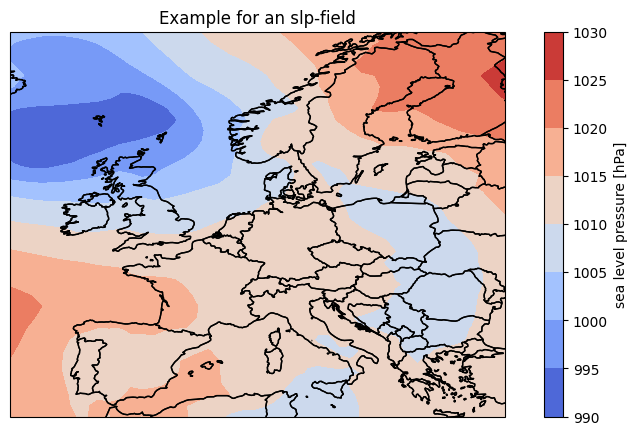

In [2]:
# Read daily sea level pressure (slp) fields (as basis for clustering) and plot example field.
# Here, only slp fields for the summer half-year are used 
pfad='DATA\\ERA5\\'
file = ''+str(pfad)+'era5_slp_AMJJAS_1961-2024_int.nc'
ncdata = Dataset(file, mode='r')
data=ncdata.variables['msl']
lat = ncdata.variables['lat'][:]  # Breiten
lon = ncdata.variables['lon'][:] 
slp=data[:,:,:]
tvar = ncdata.variables['time']
tunits = tvar.units
time_data = tvar[:]
sdate_str = '1961-04-01 11:30:00'
sdate = datetime.strptime(sdate_str, '%Y-%m-%d %H:%M:%S')
dates = [sdate + timedelta(hours=int(hour)) for hour in time_data]
edates = [date.strftime('%Y-%m-%d') for date in dates]

# coastlines and natinal borrders 
coastl = ShapelyFeature(Reader(fcoastl).geometries(), ccrs.PlateCarree(), edgecolor="black",facecolor="none")
country = ShapelyFeature(Reader(fcountry).geometries(), ccrs.PlateCarree(), edgecolor="gray",facecolor="none")

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-15, 30, 35, 70], crs=ccrs.PlateCarree())
ax.add_feature(coastl,linestyle='-', edgecolor='black')
ax.add_feature(country,linestyle='-', edgecolor='black')
plt.contourf(lon, lat, slp[400,:,:]/100., cmap='coolwarm', transform=ccrs.PlateCarree())
ax.set_title("Example for an slp-field")
plt.colorbar(label='sea level pressure [hPa]')
plt.show()

# CLUSTERING OF SLP-Fields
To identify recurring weather patterns, the slp fields are clustered. The clustering consists of two steps:  
1.) self-organizing maps (SOM), a type of artificial neural network used for dimensionality reduction. SOMs have the advantage of being able to identify rare clusters.  
2.) k-Means, a clustering algorithm which is used to further reduce the SOM-cluster.  
The resulting k-means cluster are our weather types.

In [3]:
# SOM initialization and training
slp_flat = slp.reshape(slp.shape[0], -1)
scaler = MinMaxScaler()
slp_scaled = scaler.fit_transform(slp_flat)
som_x, som_y = 10, 10 
input_len = slp_scaled.shape[1]

som = MiniSom(som_x, som_y, input_len, sigma=1.0, learning_rate=0.5, random_seed=98)
som.random_weights_init(slp_scaled)
n_iterations = 5000
som.train_random(slp_scaled, n_iterations)
print("SOM Training finished")

SOM Training finished


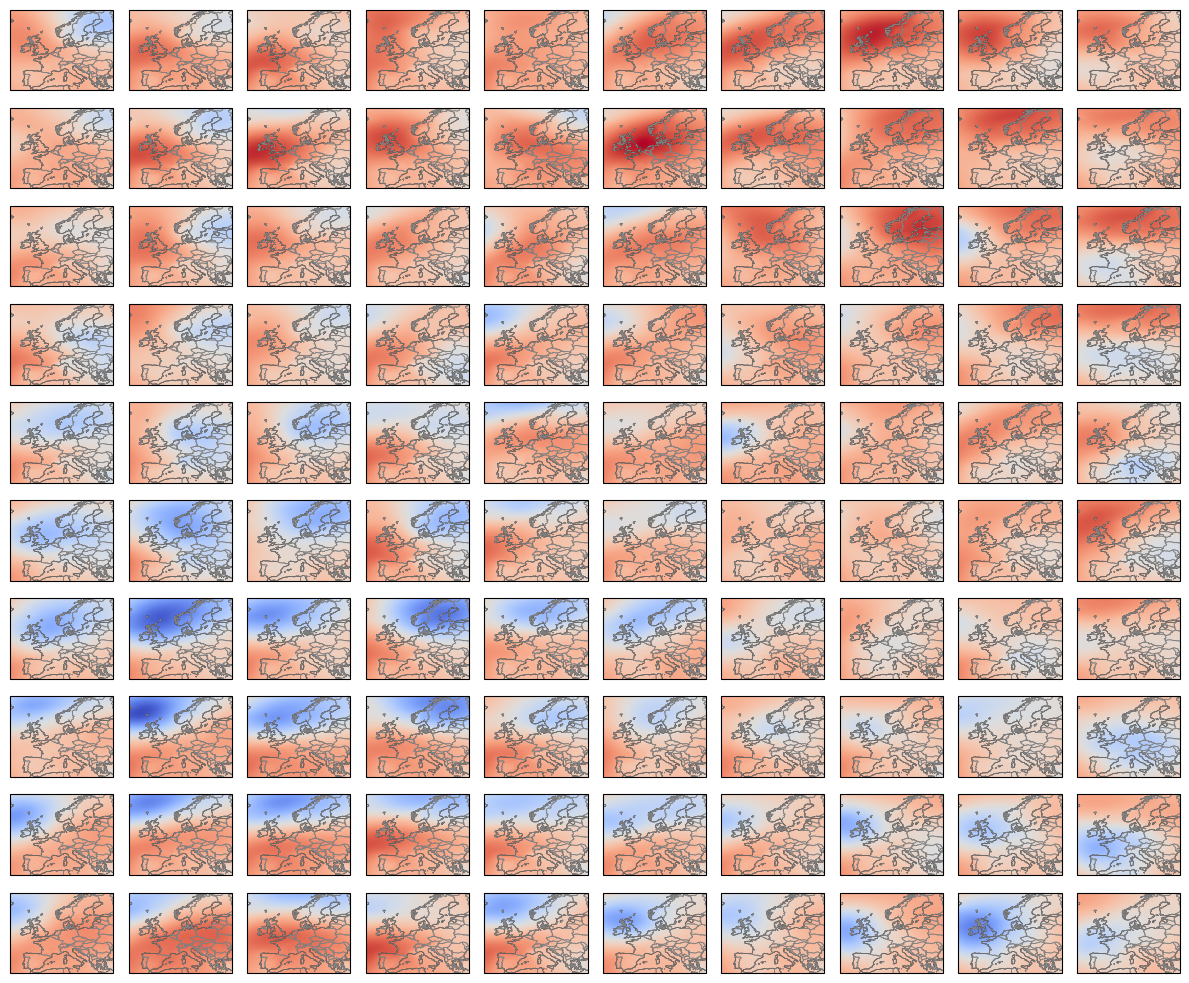

In [4]:
# plot the resulting weight vectors
bmus = np.array([som.winner(d) for d in slp_scaled])
mean = np.zeros((som_x, som_y, slp.shape[1], slp.shape[2]))
c = np.zeros((som_x, som_y))
for i, bmu in enumerate(bmus):
    x, y = bmu
    mean[x, y] += slp[i]
    c[x, y] += 1  

mean = np.divide(mean, c[:, :, np.newaxis, np.newaxis], where=c[:, :, np.newaxis, np.newaxis] != 0)

fig, axes = plt.subplots(som_x, som_y, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for x in range(som_x):
    for y in range(som_y):
        ax = axes[x, y]
        if c[x, y] > 0:
            meanf = mean[x, y]
            im = ax.imshow(meanf, cmap='coolwarm', vmin=np.min(mean), vmax=np.max(mean),
                           transform=ccrs.PlateCarree(), extent=[-15, 30, 35, 70])
            ax.add_feature(coastl, edgecolor='black', linewidth=0.5)
            ax.add_feature(country, edgecolor='gray', linewidth=0.5)
        else:
            ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.tight_layout()
plt.show()

In [5]:
# read pre-processed Tmax data and select same months and period as for slp-fields
pfad2='DATA\\DWD\\'
df = pd.read_csv(''+str(pfad2)+'tmax_19510101_20241231_04336-Saarbruecken_prepr.csv', parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])
df2 = df[(df['date'].dt.year >= 1961) & (df['date'].dt.year <= 2024)]
df2 = df2[df2['date'].dt.month.isin([4, 5, 6, 7, 8, 9])]
print(df2)

            date  Tmean  Tmax
3743  1961-04-01    8.7   9.6
3744  1961-04-02   10.0  12.3
3745  1961-04-03    9.8  11.4
3746  1961-04-04   13.2  16.7
3747  1961-04-05   15.7  20.0
...          ...    ...   ...
26932 2024-09-26   14.9  17.0
26933 2024-09-27   12.4  14.8
26934 2024-09-28    9.5  13.8
26935 2024-09-29    8.0  13.1
26936 2024-09-30   11.5  14.5

[11712 rows x 3 columns]


In [6]:
# k-Means clustering using the SOM weight vectors as input
ww = som.get_weights()
wwf = ww.reshape(-1, ww.shape[-1])
n_cl = 12  # number of k-Means cluster
kmeans = KMeans(n_clusters=n_cl, random_state=42)
c_id = kmeans.fit_predict(wwf)
centroids = kmeans.cluster_centers_

In [7]:
# Compute fields for the k-means cluster and add cluster_id (cl_cl) to dataframe df2 (Tmax dataframe).
# For each day the slp-pattern can be assigned to one of the k-Means cluster, which is indicated by the cluster_id       
clmean = np.zeros((n_cl, slp.shape[1], slp.shape[2]))
clc = np.zeros(n_cl)
df2['Cluster'] = np.nan

for i, field in enumerate(slp_scaled):
    dist = euclidean_distances([field], centroids)
    cl_cl = np.argmin(dist)
    clmean[cl_cl] += slp[i]
    clc[cl_cl] += 1
    date = pd.to_datetime(edates[i])
    if date in df2['date'].values:
        df2.loc[df2['date'] == date, 'Cluster'] = cl_cl
clmean = np.divide(clmean, clc[:, np.newaxis, np.newaxis], 
                   where=clc[:, np.newaxis, np.newaxis] != 0)

In [8]:
# Compute Tmax histograms for all clusters via the cluster_id 
bins = np.linspace(26, 38, 13)
tmaxd = df2.groupby('Cluster')['Tmax'].apply(list)
tmaxm = df2.groupby('Cluster')['Tmax'].mean()
tmaxh = {cluster: np.histogram(tmax, bins=bins) for cluster, tmax in tmaxd.items()}

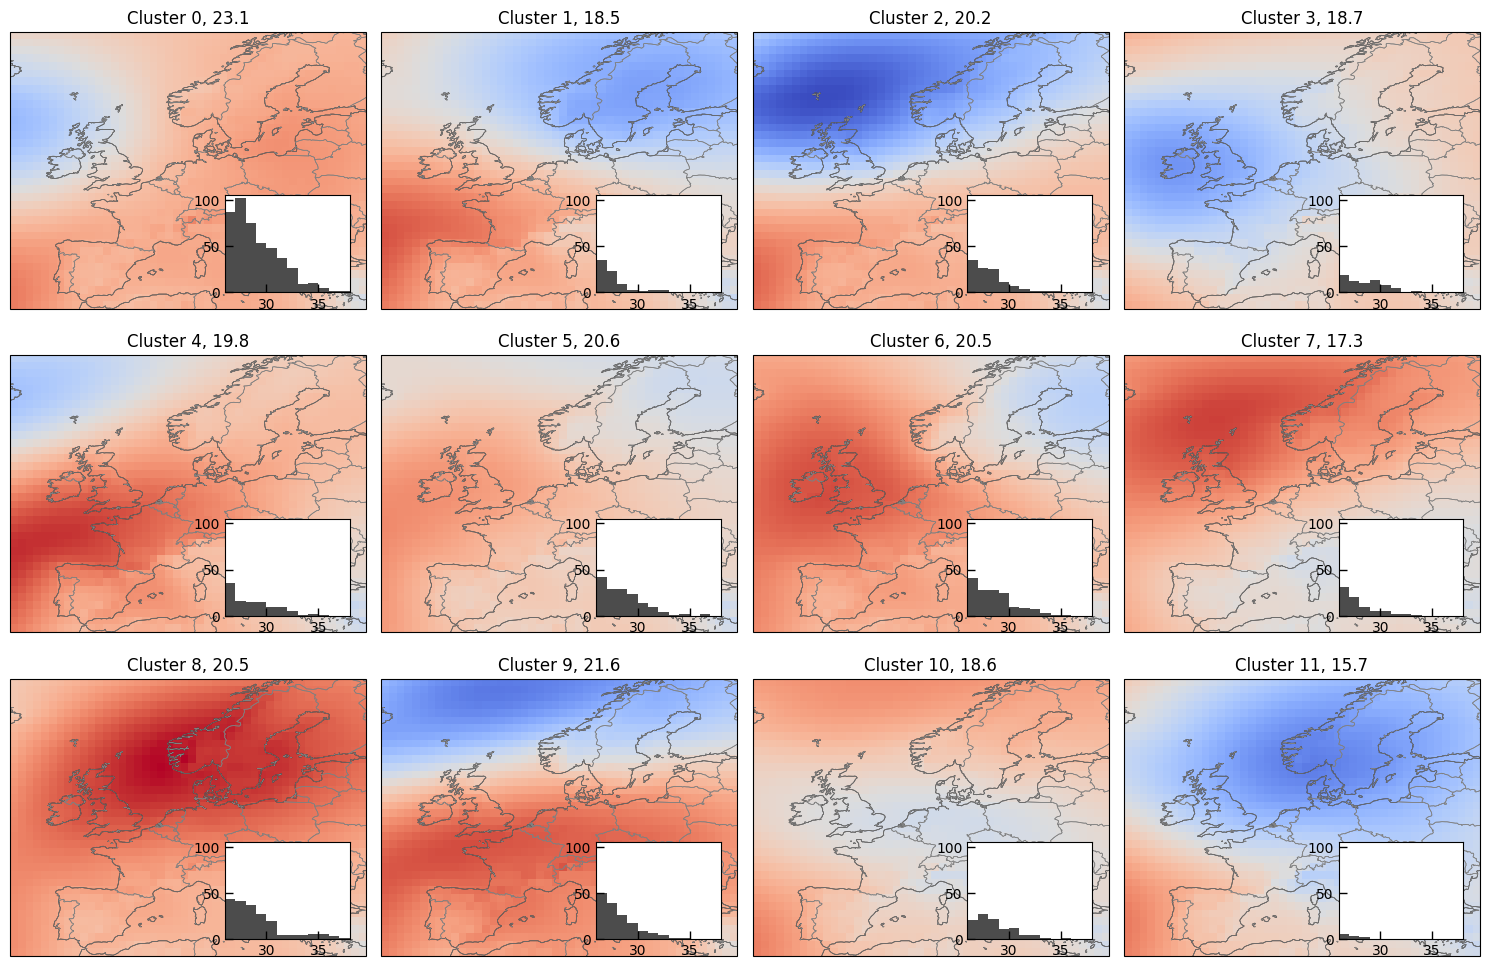

In [9]:
# plot cluster with their Tmax histogramms
import warnings
warnings.filterwarnings('ignore')
n_rows, n_cols = 3, 4  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i, (centroid, meanf, ax) in enumerate(zip(centroids, clmean, axes.flat)):
    im = ax.imshow(meanf, cmap='coolwarm', vmin=np.min(clmean), vmax=np.max(clmean),
                   transform=ccrs.PlateCarree(), extent=[-15, 30, 35, 70])
    ax.add_feature(coastl, edgecolor='black', linewidth=0.5)
    ax.add_feature(country, edgecolor='gray', linewidth=0.5)
    ax.set_title(f"Cluster {i}, {tmaxm[i]:.1f}")
    ax_inset = inset_axes(ax, width="35%", height="35%", loc='lower right', borderpad=1.2)
    tmaxv = df2[df2['Cluster'] == i]['Tmax']
    freq, bin_edges = np.histogram(tmaxv, bins=bins)
    ax_inset.bar(bin_edges[:-1], freq, width=np.diff(bin_edges), align='edge', alpha=0.7, color='black')
    ax_inset.set_xlim(26, 38)
    ax_inset.set_ylim(0, 100 + 5)
    ax_inset.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black', grid_color='black', grid_alpha=0.5)
for ax in axes.flat[len(centroids):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

The figure above shows the resulting k-means clusters (i.e., the weather types) as contour plots. Red (blue) areas represent regions with high (low) pressure. For example, Cluster 8 represents a blocking high-pressure system over Northern Europe, and Cluster 3 represents a low-pressure system over Western Europe. The number above each subplot indicates the Tmax value averaged over all days with the respective weather types, while the insets show the Tmax distribution. One weather type that stands out is Cluster 0, which includes low-pressure systems that favor the transport of warm air masses from the western Mediterranean towards Central Europe. As a consequence, this weather type shows the highest Tmax mean value and is associated with a Tmax distribution shifted towards higher values.

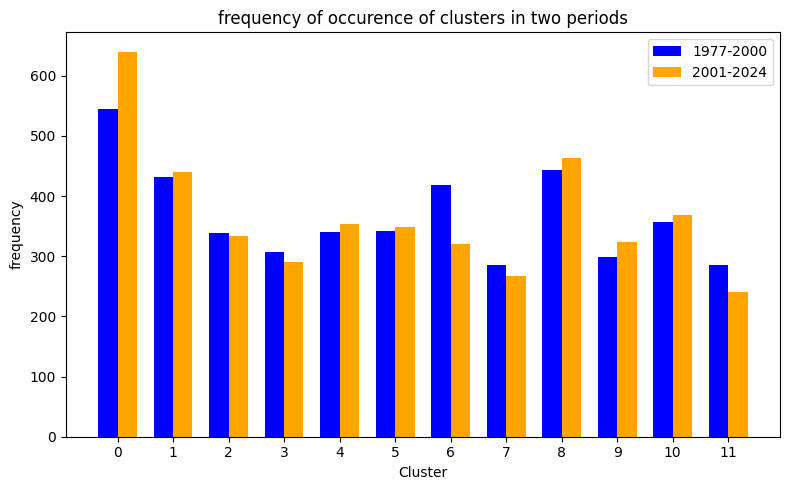

In [10]:
# plot frequency of occurence of the weather types at the end of the 20th century and in the 21st century 
period1 = df2[(df2['date'] >= '1977-01-01') & (df2['date'] <= '2000-12-31')]
period2 = df2[(df2['date'] >= '2001-01-01') & (df2['date'] <= '2024-12-31')]
cp1 = period1['Cluster'].value_counts().sort_index()
cp2 = period2['Cluster'].value_counts().sort_index()
clusters = range(n_cl)
cp1 = cp1.reindex(clusters, fill_value=0)
cp2 = cp2.reindex(clusters, fill_value=0)
x = np.arange(len(clusters))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, cp1, width, label='1977-2000', color='blue')
bars2 = ax.bar(x + width/2, cp2, width, label='2001-2024', color='orange')
ax.set_xlabel('Cluster')
ax.set_ylabel('frequency')
ax.set_title('frequency of occurence of clusters in two periods')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()
plt.tight_layout()
plt.show()

We see a clear increase in the frequency of occurrence of Cluster 0 in the 21st century. In the figure below, we show the time series of the Cluster 0 frequencies, along with the fraction of Cluster 0 days with Tmax above 30°C.

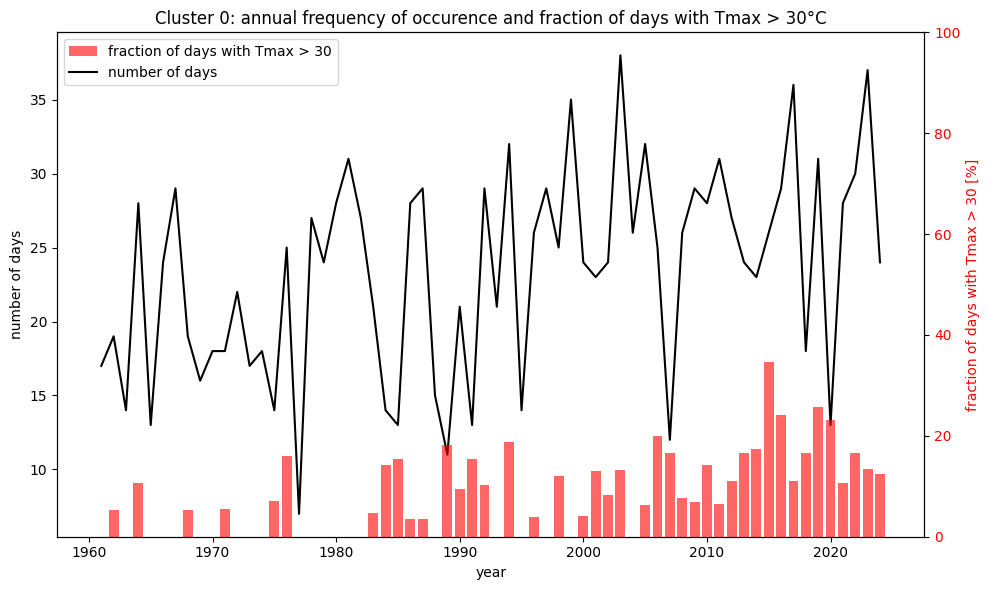

In [11]:
cl=0 # cluster of interest

df2['year'] = pd.to_datetime(df2['date']).dt.year
cl_c = df2.groupby(['year', 'Cluster']).size().reset_index(name='total_days')
hd_c = df2[df2['Tmax'] > 30].groupby(['year', 'Cluster']).size().reset_index(name='hot_days')
result = pd.merge(cl_c, hd_c, on=['year', 'Cluster'], how='left')
result['hot_days'] = result['hot_days'].fillna(0)
result['perc_hot_days'] = (result['hot_days'] / result['total_days']) * 100
result = result.sort_values(by=['year', 'Cluster'])
cl_data = result[result['Cluster'] == cl]

fig, ax1 = plt.subplots(figsize=(10, 6))
line,=ax1.plot(cl_data['year'], cl_data['total_days'], color='k', label='number of days')
ax2 = ax1.twinx()
bar=ax2.bar(cl_data['year'], cl_data['perc_hot_days'], color='r', alpha=0.6, label='fraction of days with Tmax > 30')
ax1.set_title('Cluster '+str(cl)+': annual frequency of occurence and fraction of days with Tmax > 30°C')
ax1.set_xlabel('year')
ax1.set_ylabel('number of days', color='k')
ax2.set_ylabel('fraction of days with Tmax > 30 [%]', color='r')
ax1.tick_params(axis='y', labelcolor='k')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 100)
handles = [bar, line]  # Handles der Balken und der Linie
labels = ['fraction of days with Tmax > 30', 'number of days']  # Entsprechende Labels
ax1.legend(handles=handles, labels=labels, loc='upper left')
plt.tight_layout()
plt.show()

# Interpretation
We observe a superposition of two effects that contribute to the strong increase in hot days and heat waves in the 21st century (see data-analysis_Tmax.ipynb):  
1.) The weather type (Cluster 0) associated with highest Tmax values occurs more frequently.  
2.) The fraction of days within this weather type exceeding 30°C increases.  
While the first represents a non-linear relationship between climate warming and dynamic changes, the second possibly reflects the direct effect of greenhouse gases.